In [1]:
import os
import random

import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.svm
import sklearn.tree
import tensorflow as tf

### Implement functions used in all the tasks.

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def load_images_and_labels(images_dirname, csv_label):
    """Loads images and labels.
    
    Args:
        images_dirname (str): Name of the directory which holds the data.
        csv_label (str): Name of the column from labels.csv to output.

    Returns:
        images (np.ndarray): 4-d array of images, in format np.float32, values between 0 and 1.
        labels (np.ndarray): 1-d array of labels, in format np.int8.
    """
    # get paths of images
    images_dir = os.path.join("./Datasets", images_dirname, "img")
    image_paths = sorted(
        [os.path.join(images_dir, l) for l in os.listdir(images_dir)],
        key=lambda x: int(x.split(".")[1].split("/")[-1]),
    )

    images = []
    for image_path in image_paths:
        image = (
            tf.keras.preprocessing.image.img_to_array(
                tf.keras.preprocessing.image.load_img(image_path), dtype=np.float32
            )
            / 255
        )
        images.append(image)
    images = np.array(images)

    # get labels
    labels_file = open(os.path.join("./Datasets", images_dirname, "labels.csv"), "r")
    lines = labels_file.readlines()
    labels_file.close()
    column = lines[0].split().index(csv_label) + 1
    labels = []
    for line in lines[1:]:
        line = line.split()
        value_to_append = int(line[column])
        # if -1, convert to 0
        labels.append(0 if value_to_append == -1 else value_to_append)
    labels = np.array(labels, dtype=np.int8)

    return images, labels

def shape_to_np(shape):
    """Converts shape returned by dlib into numpy array.

    Args:
        shape (dlib.full_object_detection): Object returned by dlib.
    Returns:
        np.ndarray: Coordinates of the landmarks.
    """
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype="int")

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords


def rect_to_bb(rect):
    """Converts bounding predicted by dlib into (x, y, w, h) format.
    """
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    return (x, y, w, h)


def run_dlib_shape(image):
    """Detects landmarks.

    The function detects the landmarks of the face, then returns the
    landmarks and resized image.
    """
    resized_image = image.astype("uint8")

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype("uint8")

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

def images_into_landmarks(images, labels):
    """Detects landmarks on all images, returns only where landmarks could be found.
    
    Args:
        images (np.ndarray): 4-d array of images, in format np.float32, values between 0 and 1.
        labels (np.ndarray): 1-d array of labels, in format np.int8.
    Returns:
        landmarks (np.ndarray): 3-d array of images, in format np.int16.
        labels (np.ndarray): 1-d array of labels, in format np.int8.
        undetectable (np.ndarray): 1-d array of indexes at which face couldn't be detected. In format int.
    """
    landmarks_detected = []
    labels_detected = []
    undetectable = []
    for i, image in enumerate(images):
        dlibout, _ = run_dlib_shape(image * 255.0)
        if dlibout is not None:
            landmarks_detected.append(dlibout)
            labels_detected.append(labels[i])
        else:
            undetectable.append(i)
    return np.array(landmarks_detected, dtype=np.int16), np.array(labels_detected, dtype=np.int8), undetectable

def flatten_examples(examples):
    """Flattens ndarray except the top dimension.

    Args:
        examples (np.ndarray): Array of examples, each can contain more arrays.
    Returns:
        np.ndarray: 2-d array, where each element is a flattened example.
    """
    return examples.reshape((examples.shape[0], -1))

# Task A1
Gender detection: male or female.

Structure:
* import all images and labels
* plot a few examples to make sure it's imported well
* split into train, validation, test sets
* try a few approaches:
  * use dlib to extract the landmarks, plot overlayed:
    * use a few shallow learning algos and compare, do hyperparameter optimization for each
  * a few shallow algos on pure pixels
  * use CNN
* test on the test set using the best model

##### Import all images and labels.

In [3]:
a1_X_train_raw_images, a1_y_train_raw = load_images_and_labels("celeba", "gender")
a1_X_test_raw_images, a1_y_test_raw = load_images_and_labels("celeba_test", "gender")

##### Plot a few examples to make sure it's imported well.

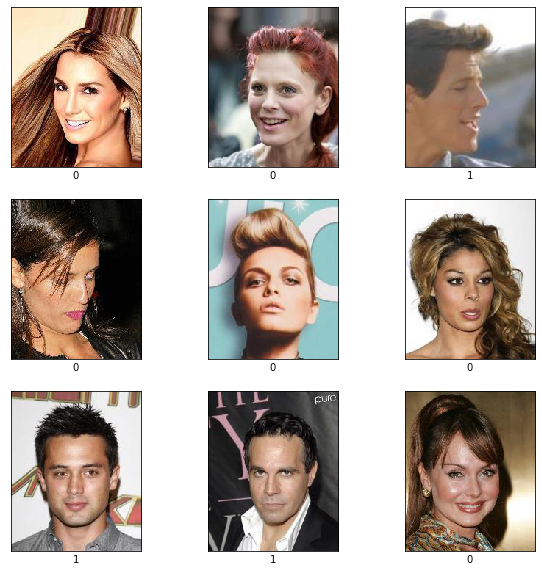

In [4]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(a1_X_train_raw_images[i], cmap=plt.cm.binary)
    plt.xlabel(a1_y_train_raw[i])

plt.show()

##### Split images and labels into train, validation, and test sets.

In [4]:
a1_X_train_images, a1_X_validation_images, a1_y_train, a1_y_validation = sklearn.model_selection.train_test_split(a1_X_train_raw_images, a1_y_train_raw)
a1_X_test_images, a1_y_test = a1_X_test_raw_images, a1_y_test_raw

### Try a few models.
##### Begin with extracting the landmarks using dlib.

In [5]:
a1_X_train_landmarks, a1_y_train_landmarks, a1_undetectable_train = images_into_landmarks(a1_X_train_images, a1_y_train)
a1_X_validation_landmarks, a1_y_validation_landmarks, _ = images_into_landmarks(a1_X_validation_images, a1_y_validation)
a1_X_test_landmarks, a1_y_test_landmarks, _ = images_into_landmarks(a1_X_test_images, a1_y_test)

##### Plot the extracted features on top of the pictures.

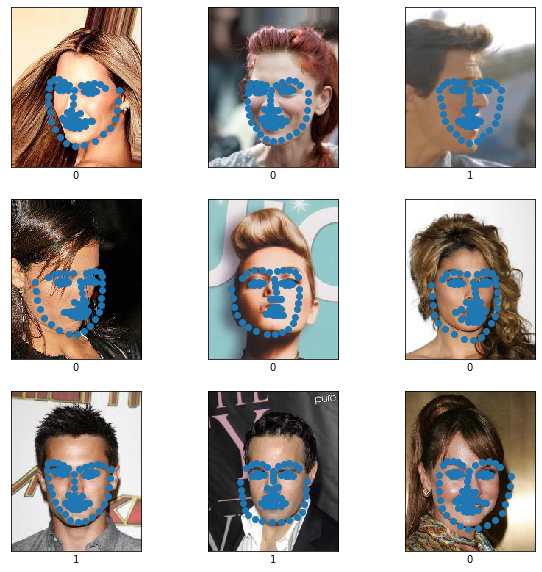

In [7]:
plt.figure(figsize=(10, 10))

offset = 0
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(a1_X_train_raw_images[i], cmap=plt.cm.binary)
    plt.xlabel(a1_y_train_raw[i])
    if i in a1_undetectable_train:
        offset = offset + 1
        continue
    plt.scatter(a1_X_train_landmarks[i - offset][:, 0], a1_X_train_landmarks[i - offset][:, 1])

plt.show()

##### SVM on landmarks.

In [8]:
a1_svm_params = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "kernel": ["linear", "poly", "linear", "sigmoid"]
}
a1_svm = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(), a1_svm_params)
a1_svm.fit(flatten_examples(a1_X_train_landmarks), a1_y_train_landmarks)
print(a1_svm.best_params_)
a1_pred_svm_validation = a1_svm.predict(flatten_examples(a1_X_validation_landmarks))
sklearn.metrics.accuracy_score(a1_y_validation_landmarks, a1_pred_svm_validation)

{'C': 10.0, 'kernel': 'poly'}


0.9208333333333333

##### Decision tree classifier on landmarks.

In [9]:
a1_dtc_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 5, 10, 50, 100, 500, None]
}
a1_dtc = sklearn.model_selection.GridSearchCV(sklearn.tree.DecisionTreeClassifier(), a1_dtc_params)
a1_dtc.fit(flatten_examples(a1_X_train_landmarks), a1_y_train_landmarks)
print(a1_dtc.best_params_)
a1_pred_dtc_validation = a1_dtc.predict(flatten_examples(a1_X_validation_landmarks))
sklearn.metrics.accuracy_score(a1_y_validation_landmarks, a1_pred_dtc_validation)

{'criterion': 'entropy', 'max_depth': 5}


0.8116666666666666

##### SVM on all pixels.

In [10]:
a1_svm_pixels = sklearn.svm.SVC(C=1.0, kernel="poly")
a1_svm_pixels.fit(flatten_examples(a1_X_train_images), a1_y_train)
a1_pred_svm_pixels_validation = a1_svm_pixels.predict(flatten_examples(a1_X_validation_images))
sklearn.metrics.accuracy_score(a1_y_validation, a1_pred_svm_pixels_validation)

0.8944

##### CNN on all pixels.

In [11]:
a1_model = tf.keras.models.Sequential()
a1_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(218, 178, 3)))
a1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
a1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
a1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
a1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
a1_model.add(tf.keras.layers.Flatten())
a1_model.add(tf.keras.layers.Dense(64, activation='relu'))
a1_model.add(tf.keras.layers.Dense(2, activation='softmax'))

a1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 41, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 133824)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8

Train on 3750 samples, validate on 1250 samples
Epoch 1/5
3750/3750 [==============================] - 84s 23ms/sample - loss: 0.5492 - accuracy: 0.7136 - val_loss: 0.5548 - val_accuracy: 0.7152
Epoch 2/5
3750/3750 [==============================] - 88s 23ms/sample - loss: 0.2806 - accuracy: 0.8912 - val_loss: 0.2387 - val_accuracy: 0.8960
Epoch 3/5
3750/3750 [==============================] - 89s 24ms/sample - loss: 0.1621 - accuracy: 0.9341 - val_loss: 0.2267 - val_accuracy: 0.9088
Epoch 4/5
3750/3750 [==============================] - 87s 23ms/sample - loss: 0.0783 - accuracy: 0.9693 - val_loss: 0.3048 - val_accuracy: 0.8864
Epoch 5/5
3750/3750 [==============================] - 89s 24ms/sample - loss: 0.0419 - accuracy: 0.9853 - val_loss: 0.2918 - val_accuracy: 0.9176


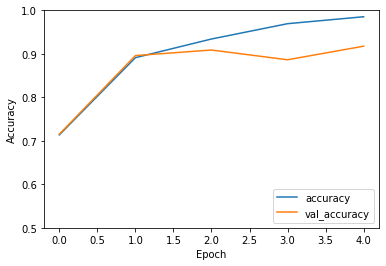

In [12]:
a1_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = a1_model.fit(
    a1_X_train_images,
    a1_y_train,
    epochs=5,
    validation_data=(a1_X_validation_images, a1_y_validation),
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

In [13]:
_, a1_cnn_test_accuracy = a1_model.evaluate(a1_X_test_images, a1_y_test, verbose=2)

1000/1 - 6s - loss: 0.9971 - accuracy: 0.9030


In [14]:
a1_cnn_test_accuracy

0.903

# Task A2
Emotion detection: smiling or not smiling.

Structure:
* import all images and labels
* no need to split into validation and train sets
* train CNN (clearly the best approach on task A1, so it will be used here)
* report on the test set

##### Import all images and labels.

In [8]:
a2_X_train_raw_images, a2_y_train_raw = load_images_and_labels("celeba", "smiling")
a2_X_test_raw_images, a2_y_test_raw = load_images_and_labels("celeba_test", "smiling")

In [9]:
a2_X_train_images, a2_y_train = a2_X_train_raw_images, a2_y_train_raw
a2_X_test_images, a2_y_test = a2_X_test_raw_images, a2_y_test_raw

##### CNN on all pixels.

In [10]:
a2_model = tf.keras.models.Sequential()
a2_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(218, 178, 3)))
a2_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
a2_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
a2_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
a2_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
a2_model.add(tf.keras.layers.Flatten())
a2_model.add(tf.keras.layers.Dense(64, activation='relu'))
a2_model.add(tf.keras.layers.Dense(2, activation='softmax'))

a2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 41, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 133824)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8

Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 122s 24ms/sample - loss: 0.6798 - accuracy: 0.6576 - val_loss: 0.4525 - val_accuracy: 0.7820
Epoch 2/10
5000/5000 [==============================] - 117s 23ms/sample - loss: 0.3534 - accuracy: 0.8428 - val_loss: 0.3914 - val_accuracy: 0.8160
Epoch 3/10
5000/5000 [==============================] - 119s 24ms/sample - loss: 0.2891 - accuracy: 0.8726 - val_loss: 0.4163 - val_accuracy: 0.8110
Epoch 4/10
5000/5000 [==============================] - 118s 24ms/sample - loss: 0.2316 - accuracy: 0.9044 - val_loss: 0.3410 - val_accuracy: 0.8600
Epoch 5/10
5000/5000 [==============================] - 119s 24ms/sample - loss: 0.1857 - accuracy: 0.9242 - val_loss: 0.3530 - val_accuracy: 0.8640
Epoch 6/10
5000/5000 [==============================] - 122s 24ms/sample - loss: 0.1279 - accuracy: 0.9524 - val_loss: 0.3969 - val_accuracy: 0.8670
Epoch 7/10
5000/5000 [==============================] - 12

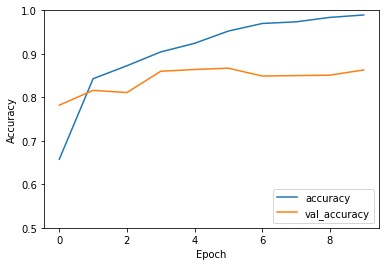

In [11]:
a2_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = a2_model.fit(
    a2_X_train_images,
    a2_y_train,
    epochs=10,
    validation_data=(a2_X_test_images, a2_y_test),
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

In [14]:
_, a2_cnn_test_accuracy = a2_model.evaluate(a2_X_test_images, a2_y_test, verbose=2)

1000/1 - 7s - loss: 0.4731 - accuracy: 0.8680


In [15]:
a2_cnn_test_accuracy

0.868

# Task B1
Face shape recognition: 5 types of face shapes.

Structure:
* import all images and labels
* plot a few examples to make sure it's imported well
* split into train, validation, test sets
* use dlib to extract the landmarks, plot overlayed
  * try SVM
* use CNN (crop images)
* test on the test set using CNN

##### Import all images and labels.

In [21]:
b1_X_train_raw_images, b1_y_train_raw = load_images_and_labels("cartoon_set", "face_shape")
b1_X_test_raw_images, b1_y_test_raw = load_images_and_labels("cartoon_set_test", "face_shape")

##### Plot a few examples to make sure it's imported well.

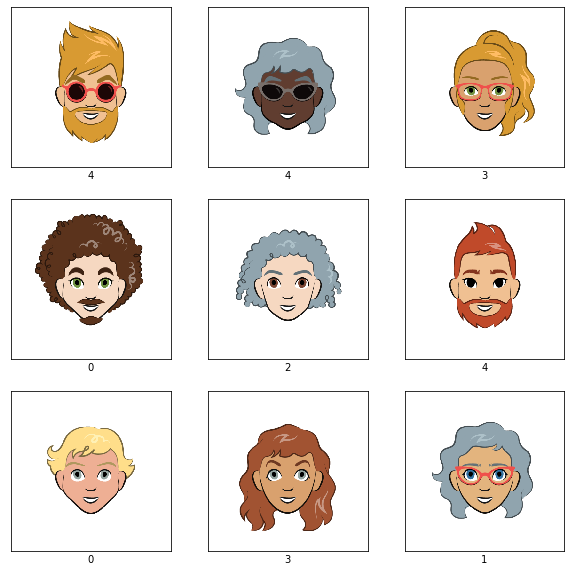

In [22]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(b1_X_train_raw_images[i], cmap=plt.cm.binary)
    plt.xlabel(b1_y_train_raw[i])

plt.show()

##### Split images and labels into train, validation, and test sets.

In [23]:
b1_X_train_images, b1_X_validation_images, b1_y_train, b1_y_validation = sklearn.model_selection.train_test_split(b1_X_train_raw_images, b1_y_train_raw)
b1_X_test_images, b1_y_test = b1_X_test_raw_images, b1_y_test_raw

##### Extract the landmarks using dlib.

In [24]:
b1_X_train_landmarks, b1_y_train_landmarks, b1_undetectable_train = images_into_landmarks(b1_X_train_images, b1_y_train)
b1_X_validation_landmarks, b1_y_validation_landmarks, _ = images_into_landmarks(b1_X_validation_images, b1_y_validation)
b1_X_test_landmarks, b1_y_test_landmarks, _ = images_into_landmarks(b1_X_test_images, b1_y_test)

##### Plot the extracted features on top of the pictures.

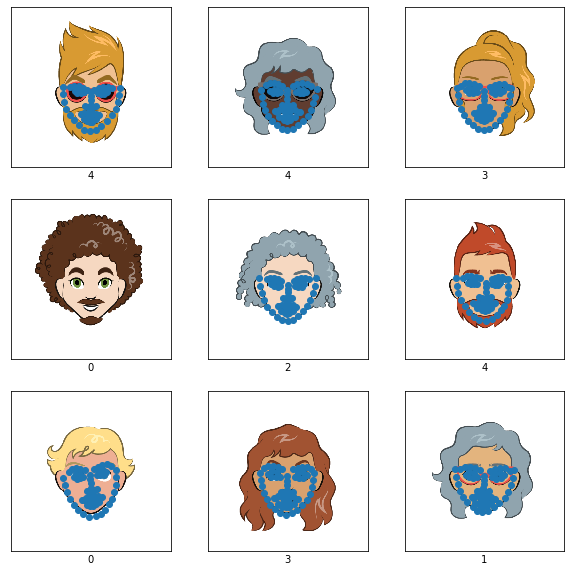

In [25]:
plt.figure(figsize=(10, 10))

offset = 0
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(b1_X_train_raw_images[i], cmap=plt.cm.binary)
    plt.xlabel(b1_y_train_raw[i])    
    if i in b1_undetectable_train:
        offset = offset + 1
        continue
    plt.scatter(b1_X_train_landmarks[i - offset][:, 0], b1_X_train_landmarks[i - offset][:, 1])

plt.show()

The detection is not always very correct, so we don't expect high accuracy here. Let's try SVM on the landmarks.
##### SVM on landmarks.

In [26]:
b1_svm = sklearn.svm.SVC(kernel="poly")
b1_svm.fit(flatten_examples(b1_X_train_landmarks), b1_y_train_landmarks)
b1_pred_svm_validation = b1_svm.predict(flatten_examples(b1_X_validation_landmarks))
sklearn.metrics.accuracy_score(b1_y_validation_landmarks, b1_pred_svm_validation)

0.7516940948693127

##### CNN on all pixels.

In [27]:
b1_model = tf.keras.models.Sequential()
b1_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)))
b1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
b1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
b1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
b1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
b1_model.add(tf.keras.layers.Flatten())
b1_model.add(tf.keras.layers.Dense(64, activation='relu'))
b1_model.add(tf.keras.layers.Dense(5, activation='softmax'))

b1_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 121, 121, 64)      36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 937024)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

##### Crop images.
Notice the very high number of parameters (60,000,000), large portions of the images are outside the face, can be cropped.

In [28]:
b1_X_train_images_cropped = tf.image.crop_to_bounding_box(b1_X_train_images, 150, 150, 250, 200)
b1_X_validation_images_cropped = tf.image.crop_to_bounding_box(b1_X_validation_images, 150, 150, 250, 200)
b1_X_test_images_cropped = tf.image.crop_to_bounding_box(b1_X_test_images, 150, 150, 250, 200)

##### Plot copped images.

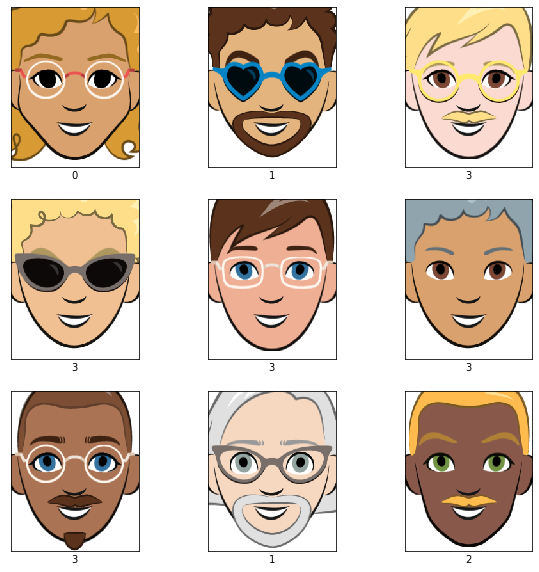

In [29]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(b1_X_train_images_cropped[i], cmap=plt.cm.binary)
    plt.xlabel(b1_y_train[i])

plt.show()

##### CNN on cropped images.

In [30]:
b1_model = tf.keras.models.Sequential()
b1_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 200, 3)))
b1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
b1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
b1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
b1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
b1_model.add(tf.keras.layers.Flatten())
b1_model.add(tf.keras.layers.Dense(64, activation='relu'))
b1_model.add(tf.keras.layers.Dense(5, activation='softmax'))

b1_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 248, 198, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 124, 99, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 122, 97, 64)       18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 48, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 59, 46, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 173696)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

Train on 7500 samples, validate on 2500 samples
Epoch 1/5
7500/7500 [==============================] - 243s 32ms/sample - loss: 0.3242 - accuracy: 0.9079 - val_loss: 0.0053 - val_accuracy: 0.9980
Epoch 2/5
7500/7500 [==============================] - 227s 30ms/sample - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.0031 - val_accuracy: 0.9984
Epoch 3/5
7500/7500 [==============================] - 219s 29ms/sample - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 4/5
7500/7500 [==============================] - 216s 29ms/sample - loss: 0.0016 - accuracy: 0.9997 - val_loss: 3.3219e-04 - val_accuracy: 1.0000
Epoch 5/5
7500/7500 [==============================] - 220s 29ms/sample - loss: 3.4349e-05 - accuracy: 1.0000 - val_loss: 2.4370e-04 - val_accuracy: 1.0000


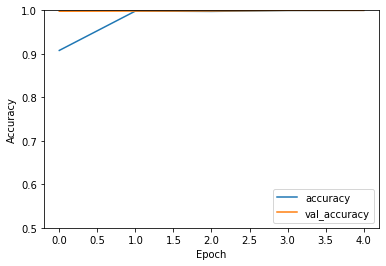

In [31]:
b1_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = b1_model.fit(
    b1_X_train_images_cropped,
    b1_y_train,
    epochs=5,
    validation_data=(b1_X_validation_images_cropped, b1_y_validation),
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

In [32]:
_, b1_cnn_test_accuracy = b1_model.evaluate(b1_X_test_images_cropped, b1_y_test, verbose=2)

2500/1 - 19s - loss: 2.7489e-04 - accuracy: 0.9996


In [33]:
b1_cnn_test_accuracy

0.9996

# Task B2
Eye color recognition: 5 eye colors.

Eye color label:
* 0 - brown
* 1 - blue
* 2 - green
* 3 - bright green
* 4 - black

Structure:
* import all images and labels
* crop images to see eyes only
* use CNN
* test on the test set using CNN

##### Import all images and labels.

In [3]:
b2_X_train_raw_images, b2_y_train_raw = load_images_and_labels("cartoon_set", "eye_color")
b2_X_test_raw_images, b2_y_test_raw = load_images_and_labels("cartoon_set_test", "eye_color")

##### Crop the images to see the eyes only.

In [4]:
b2_X_train_images = tf.image.crop_to_bounding_box(b2_X_train_raw_images, 250, 180, 30, 140)
b2_X_test_images = tf.image.crop_to_bounding_box(b2_X_test_raw_images, 250, 180, 30, 140)
b2_y_train = b2_y_train_raw
b2_y_test = b2_y_test_raw

##### Plot the cropped images.

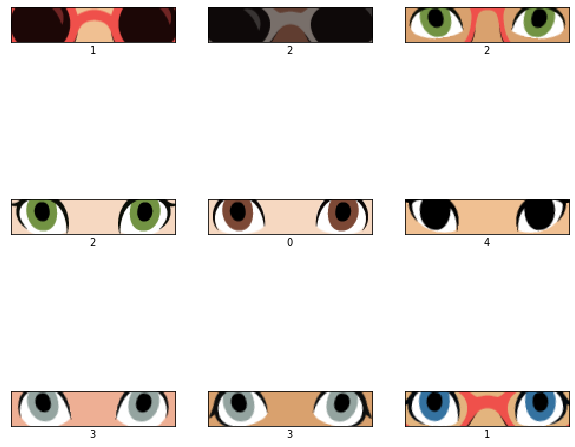

In [5]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(b2_X_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(b2_y_train_raw[i])

plt.show()

##### CNN on cropped images.

In [6]:
b2_model = tf.keras.models.Sequential()
b2_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 140, 3)))
b2_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
b2_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
b2_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
b2_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
b2_model.add(tf.keras.layers.Flatten())
b2_model.add(tf.keras.layers.Dense(64, activation='relu'))
b2_model.add(tf.keras.layers.Dense(5, activation='softmax'))

b2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 138, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 69, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 67, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 33, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 31, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 7936)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

Train on 10000 samples, validate on 2500 samples
Epoch 1/5
10000/10000 [==============================] - 23s 2ms/sample - loss: 0.4318 - accuracy: 0.8136 - val_loss: 0.3116 - val_accuracy: 0.8500
Epoch 2/5
10000/10000 [==============================] - 24s 2ms/sample - loss: 0.3050 - accuracy: 0.8498 - val_loss: 0.3027 - val_accuracy: 0.8548
Epoch 3/5
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.3043 - accuracy: 0.8491 - val_loss: 0.3013 - val_accuracy: 0.8460
Epoch 4/5
10000/10000 [==============================] - 23s 2ms/sample - loss: 0.2993 - accuracy: 0.8518 - val_loss: 0.3009 - val_accuracy: 0.8460
Epoch 5/5
10000/10000 [==============================] - 26s 3ms/sample - loss: 0.2991 - accuracy: 0.8506 - val_loss: 0.3009 - val_accuracy: 0.8460


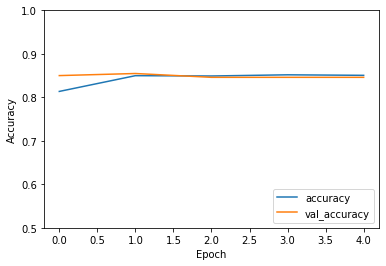

In [7]:
b2_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = b2_model.fit(
    b2_X_train_images,
    b2_y_train,
    epochs=5,
    validation_data=(b2_X_test_images, b2_y_test),
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

In [8]:
_, b2_cnn_test_accuracy = b2_model.evaluate(b2_X_test_images, b2_y_test, verbose=2)

2500/1 - 2s - loss: 0.3511 - accuracy: 0.8460


In [9]:
b2_cnn_test_accuracy

0.846